# Занятие 5: Вычисление параметров для молекулярной механики

### Лев Мазаев, мАДБМ18

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.style.use('ggplot')
%matplotlib inline
from scipy import optimize
from IPython.display import Markdown as md
from IPython.display import Image

Описание для входной функции добавлено из мануала ORCA:

In [2]:
def inp(rn=1.52986, an=111.2, dn=180):
    '''
    AtomN NA NB NC RN AN DN
    NA: The atom that the actual atom has a distance (RN) with.
    NB: The actual atom has an angle (AN) with atoms NA and NB.
    NC: The actual atom has a dihedral angle (DN) with atoms NA, NB and NC.
    This is the angle between the actual atom and atom NC when looking down the NA-NB axis.
    '''    
    return f'''
    ! HF RHF 6-31G
    * int 0 1
    C 0 0 0 0 0 0 
    C 1 0 0 {rn} 0 0 
    H 1 2 0 1.08439 {an} 0
    H 1 2 3 1.08439 {an} 120
    H 1 2 3 1.08439 {an} -120
    H 2 1 3 1.08439 {an} {dn}
    H 2 1 6 1.08439 {an} 120 
    H 2 1 6 1.08439 {an} -120
    *
    '''

inp = np.vectorize(inp)

Исходные значения параметров:

In [3]:
params = {'rn': 1.52986,  # длина связи C-C
          'an': 111.2,  # угол H-C-C
          'dn': 180}  # торсионный угол C-C
w, h = 9, 6  # для графиков

Функция, получающая расчёт в ORCA:

In [4]:
def run_orca(inp):
    with open('orca.inp', 'w') as outfile:
        outfile.write(inp)
    p = subprocess.Popen('/home/shad/progs/bin/orca orca.inp',
                        shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out=p.communicate()[0]
    
    for line in out.splitlines():
        line = line.decode('utf-8')
        if line.startswith('FINAL SINGLE POINT ENERGY'):
            return(float(line.split()[4]))
        
energy = np.vectorize(run_orca)

### 1. Зависимость энергии молекулы от длины связи C-C

In [5]:
dist = np.linspace(start=params['rn']-0.2, stop=params['rn']+0.2, num=21)  # вектор расстояний C-C

In [6]:
e_by_dist = energy(inp(rn=dist))  # вектор энергий

Посмотрим, что получилось:

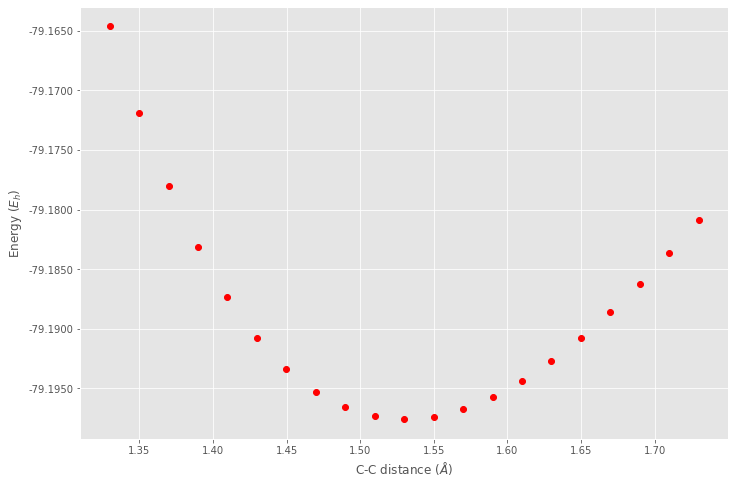

In [7]:
fig = plt.figure(figsize=(w, h))
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
ax.plot(dist, e_by_dist, 'ro')
ax.set_xlabel('C-C distance ($\AA$)')
ax.set_ylabel('Energy ($E_h$)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.show()

Теперь попробуем приблизить эту зависимость квадратичной функций:

In [8]:
def fit(x, y, fitfunc, p0, xlab, ylab, default):
    
    errfunc = lambda p, x, y: fitfunc(p, x) - y  # функция ошибок
    p1, success = optimize.leastsq(errfunc, p0, args=(x, y))
    fig = plt.figure(figsize=(w, h))
    ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
    ax.plot(x, y, 'ro', x, fitfunc(p1, x), 'b-')
    ax.axvline(x=default, linewidth=0.5, color='g', linestyle='-.')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.legend(('Real', 'Approximation', 'Ref. Value'), facecolor='w')
    fig.show()
    print(f'MSE = {np.mean((y - fitfunc(p1, x))**2):.3g}')
    print(f'Default value = {default}')
    return p1

In [9]:
fitfunc = lambda p, x: p[0] * pow(p[1] - x, 2) + p[2]  # функция, которой приближаем

MSE = 2.02e-06
Default value = 1.52986


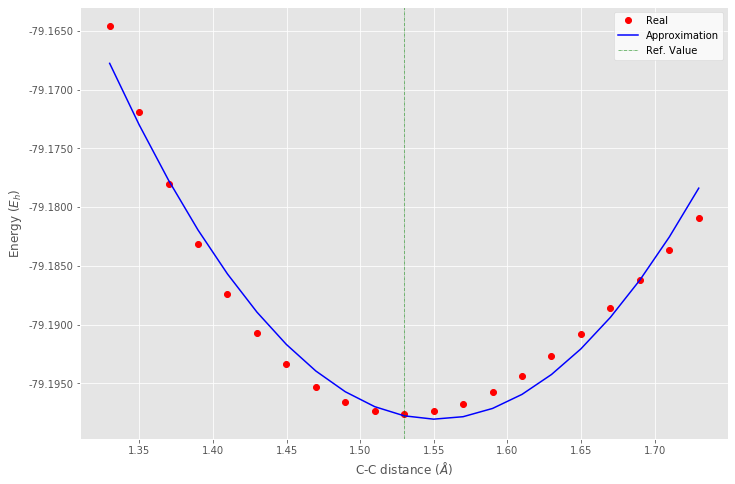

In [10]:
prn = fit(x=dist, y=e_by_dist, fitfunc=fitfunc, p0=(1, 1.5, -79.18),
           xlab='C-C distance ($\AA$)', ylab='Energy ($E_h$)',
           default=params['rn'])

Итак, получили следующую функцию, приближающую зависимость энергии от длины связи:

In [11]:
md('$E(d)={:.3f}\cdot(d-{:.3f})^2{:.3f}$'.format(*prn))

$E(d)=0.617\cdot(d-1.551)^2-79.198$

В статье о разработке поля GAFF приведена функция:

$$
E_\text{pair} = 
\sum_{\text{bonds}}k_{r}(r-r_{\text{er}})^{2} + 
\sum_{\text{angles}}k_{\theta}(\theta-\theta_{\text{er}})^{2} +
\sum_{\text{dihedrals}}\frac{\upsilon_{n}}{2}\times[1+\cos{(n\phi-\gamma)}] +
\sum_{\text{i < j}}\left[\frac{A_{ij}}{R_{ij}^{12}}-\frac{B_{ij}}{R_{ij}^{6}}+\frac{q_iq_j}{\varepsilon R_{ij}}\right]
$$


где:
- $r_\text{er}$ и $\theta_\text{er}$ - равновесные значения длин связей и валентных углов
- $k_{r}$, $k_{\theta}$, $\upsilon_{n}$ - константы силового поля
- $n$ и $\gamma$ - кратность и фазовый угол как параметры торсионного угла
- $A$, $B$ и $q$ - параметры потенциалов нековалентных взаимодействий

Соответственно, в данном случае нас интересует первое слагаемое, которое соответствует длине связи. Остальные  слагаемые зафиксированы. Значит, из нашего приближения (переходя сразу из Ha в ккал/моль)


$$
k_{r} = 
0.617 \frac{\text{Ha}}{Å^{2}} \times 
627.509 \frac{\text{kcal}}{\text{Ha} \cdot \text{mol}} = 
387.173 \frac{\text{kcal}}{\text{mol} \cdot Å^{2}}
$$


Теперь обратимся к результатам статьи (рис. 2):

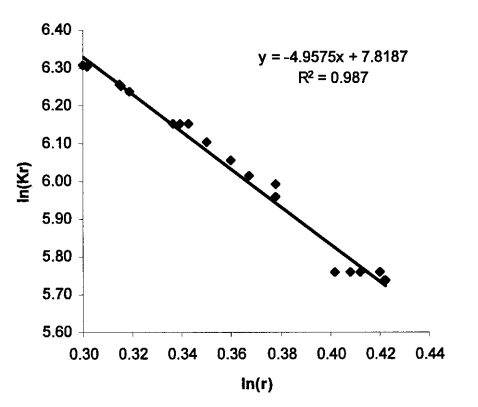

In [12]:
Image('scr1.png')

Исходя из уравнения прямой, константа будет следующей:

$$\ln(k_r)=-4.9575 \times \ln(r) + 7.8187 \implies k_r=\exp(-4.9575 \times \ln(r) + 7.8187)$$

где $r=1.526$ по данным статьи (табл. 3). Посчитаем, что получается:

In [13]:
print(f'kr={np.exp(-4.9575 * np.log(1.526) + 7.8187):.3f}')

kr=305.947


В статье $k_r=305.947 \frac{\text{kcal}}{\text{mol} \cdot Å^{2}}$, в нашей модели $k_r=387.173 \frac{\text{kcal}}{\text{mol} \cdot Å^{2}}$.  

Возможные причины расхождений:
- Разные алгоритмы вычисления: Hartree-Fock в ORCA, а в статье тестируется сам GAFF.
- В статье результат получен по многим молекулам, а мы смотрим только этан.
- Приближение точек квадратичной функцией в нашем случае не совсем верное, но иначе возникнут проблемы с интерпретацией

### 2. Зависимость энергии молекулы от валентного угла H-C-C

In [14]:
angle = np.linspace(start=params['an']-2, stop=params['an']+2, num=21)  # вектор углов H-C-C

In [15]:
e_by_angle = energy(inp(an=angle))

Посмотрим, что вышло на этот раз:

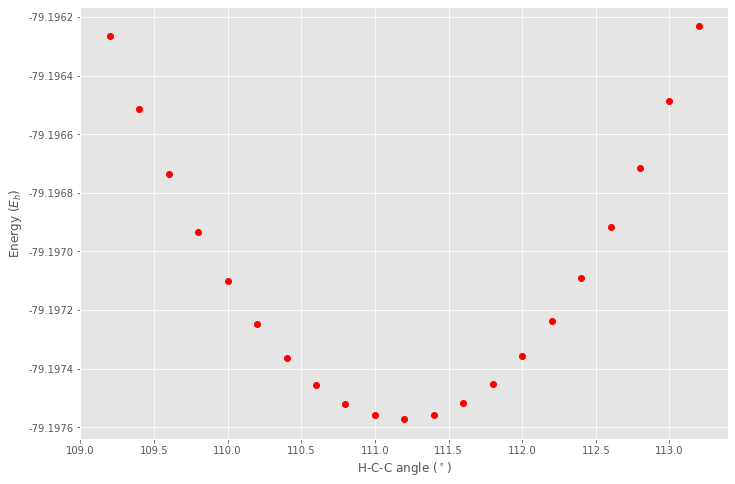

In [16]:
fig = plt.figure(figsize=(w, h))
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
ax.plot(angle, e_by_angle, 'ro')
ax.set_xlabel('H-C-C angle ($^\circ$)')
ax.set_ylabel('Energy ($E_h$)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.show()

In [17]:
fitfunc = lambda p, x: p[0] * pow(p[1] - x, 2) + p[2]  # вновь воспользуемся квадратичной функцией

MSE = 3.07e-12
Default value = 111.2


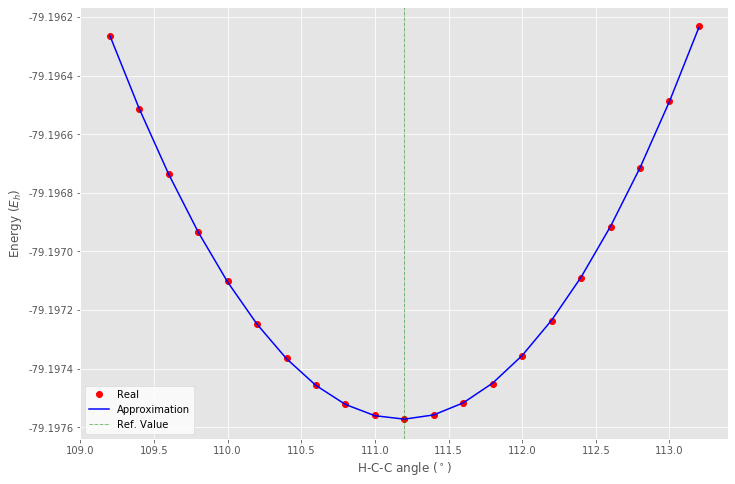

In [18]:
pan = fit(x=angle, y=e_by_angle, fitfunc=fitfunc, p0=(1, 111.2, -79.18),
           xlab='H-C-C angle ($^\circ$)', ylab='Energy ($E_h$)',
           default=params['an'])

Приближающая функция (энергия от угла H-C-C):

In [19]:
md('$E(a)={:.5f}\cdot(a-{:.3f})^2{:.3f}$'.format(*pan))

$E(a)=0.00033\cdot(a-111.190)^2-79.198$

Это соответствует второму слагаемому из формулы GAFF (остальные слагаемые фиксированы):

$$E=\sum_{\text{angles}}k_{\theta}(\theta-\theta_{\text{er}})^{2}$$

Тогда (переходя из Ha в ккал/моль и из градусов в радианы):

$$
k_{\theta} = 
0.00033 \frac{\text{Ha}}{\text{deg}^2} \times 
627.509 \frac{\text{kcal}}{\text{Ha} \cdot \text{mol}} \times
\left(57.2958 \frac{\text{deg}}{\text{rad}}\right)^2 =
679.797 \frac{\text{kcal}}{\text{mol} \cdot \text{rad}^{2}}
$$

Оценка валентного угла в статье производилась по следующей формуле:

$$
k_{ijk}^{\theta} = 
143.9 \cdot Z_{i} \cdot C_{j} \cdot Z_{k} \cdot 
\left(r_{ij}^{eq} + r_{jk}^{eq}\right)^{-1} \cdot
\left(\theta_{ijk}^{eq}\right)^{-2} \cdot
\exp \left[-2 * \frac{\left(r_{ij}^{eq}-r_{jk}^{eq}\right)^{2}}{\left(r_{ij}^{eq}+r_{jk}^{eq}\right)^{2}} \right]
$$

где
- индексы i, j и k соответствуют первому (H), второму (C) и третьму (C) атому в угле
- $Z_{i}$, $C_{j}$, $Z_{k}$ - параметры из таблицы 4
- $r_{ij}^{eq}$, $r_{jk}^{eq}$ - равновесные длины связей
- $\theta_{ijk}^{eq}$ - равновесный угол

Посчитаем, что получится:

In [20]:
z_i, c_j, z_k = 0.784, 1.339, 1.183  # табл. 4
r_ij, r_jk = 1.090, 1.526  # табл. 3
th_ijk = params['an'] * 0.01745  # в статье нет референсного угла, возьмём из наших данных и переведём в радианы
kth = 143.9 * np.prod((z_i, c_j, z_k)) * (r_ij + r_jk)**(-1) * th_ijk**(-2) * \
    np.exp(-2 * ((r_ij - r_jk) / (r_ij + r_jk))**2)
print(f'kth={kth:.3f}')

kth=17.162


Согласно нашему результату $k_{\theta}=679.797 \frac{\text{kcal}}{\text{mol} \cdot \text{rad}^{2}}$, а из данных статьи: $k_{\theta}=17.162 \frac{\text{kcal}}{\text{mol} \cdot \text{rad}^{2}}$. Расхождение получилось более, чем на порядок, возможные причины:
- Разные алгоритмы вычисления: Hartree-Fock в ORCA, а в статье тестируется сам GAFF. Второй метод предназначается всё-таки для более крупных соединений, поэтому возможно пренебрегает тем, что было бы важно для такой маленькой молекулы как этан.
- Константы Z и C - эмпирические.
- Прочие параметры модели вычислялись используя множество разных соединений.

### 3. Зависимость энергии молекулы от торсионного угла C-C 

In [21]:
dangle = np.linspace(start=-180, stop=180, num=31)  # вектор торсионных углов C-C

In [22]:
e_by_dangle = energy(inp(dn=dangle))

Посмотрим на график для торсионных углов:

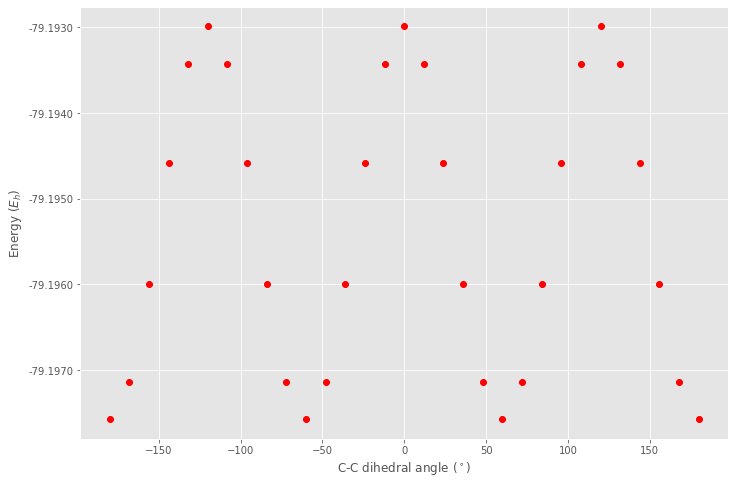

In [23]:
fig = plt.figure(figsize=(w, h))
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
ax.plot(dangle, e_by_dangle, 'ro')
ax.set_xlabel('С-С dihedral angle ($^\circ$)')
ax.set_ylabel('Energy ($E_h$)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.show()

Периодическая зависимость! Здесь придётся приближать тригонометрической функцией как в третьем слагаемом функции энергии:

$$E=\sum_{\text{dihedrals}}\frac{\upsilon_{n}}{2}\times[1+\cos{(n\phi-\gamma)}]$$

In [24]:
fitfunc = lambda p, x: (p[0] / 2) * (1 + np.cos(p[1] * x - p[2])) + p[3]  # приблизим косинусоидальной функцией

MSE = 9.96e-12
Default value = 180


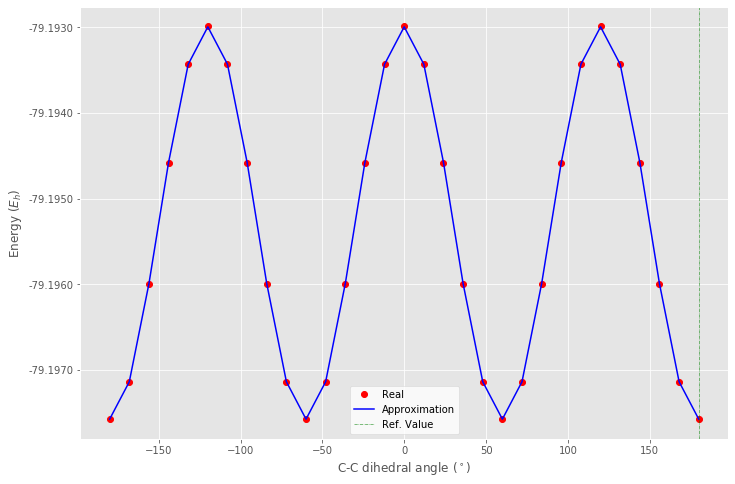

In [25]:
pdn = fit(x=dangle, y=e_by_dangle, fitfunc=fitfunc, p0=(1, 1, 0, -79.195),
           xlab='С-С dihedral angle ($^\circ$)', ylab='Energy ($E_h$)',
           default=params['dn'])

Приближающая функция:

In [26]:
md(r'$E(\phi)={0:.5f} \cdot \left[1 + \cos \left({1:.4f} \cdot \phi {2:.4f} \right) \right] {3:.3f}$'.format(*pdn))

$E(\phi)=0.00458 \cdot \left[1 + \cos \left(0.9948 \cdot \phi -0.0000 \right) \right] -79.198$

На графике видны 4 точки локального минимум, две из них в точках -180 и 180 градусов, что соответствует ожиданиям (минимум энергии в конформации с 180-градусным углом).

### 4. Зависимость энергии молекулы от длины связи C-C с шагом в $0.1 Å$

In [27]:
distB = np.linspace(start=params['rn']-1, stop=params['rn']+1, num=21)  # вектор расстояний C-C

In [28]:
e_by_distB = energy(inp(rn=distB))  # вектор энергий

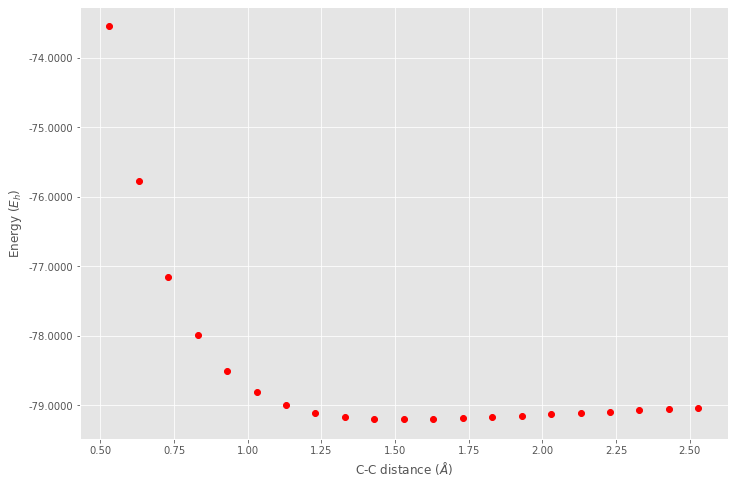

In [29]:
fig = plt.figure(figsize=(w, h))
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0))
ax.plot(distB, e_by_distB, 'ro')
ax.set_xlabel('C-C distance ($\AA$)')
ax.set_ylabel('Energy ($E_h$)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
fig.show()

Очевидно, при таком масштабе зависимость стала экспоненциальной, нужна соответствующая функция:

$$E(d)=c \cdot \exp(a \cdot d + b) + \varepsilon$$

In [30]:
fitfunc = lambda p, x: p[0] * np.exp(p[1] * x + p[2]) + p[3]  # экспоненциальная функция

MSE = 0.00417
Default value = 1.52986


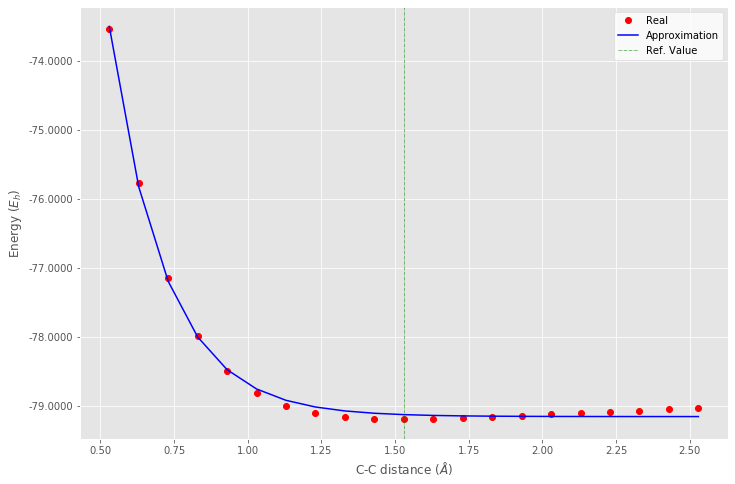

In [31]:
prnB = fit(x=distB, y=e_by_distB, fitfunc=fitfunc, p0=(1, -1, 1, -79),
           xlab='C-C distance ($\AA$)', ylab='Energy ($E_h$)',


Приближающая функция:

In [32]:
md(r'$E(d)={0:.5f} \cdot \exp \left({1:.4f} \cdot d + {2:.4f}\right) {3:.3f}$'.format(*prnB))

$E(d)=3.43519 \cdot \exp \left(-5.2975 \cdot d + 3.3054\right) -79.160$